### Sources

In [1]:
# https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN/tree/master
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
# https://github.com/pytorch/tutorials/blob/main/intermediate_source/reinforcement_q_learning.py

# For debiggung purposes ChatGPT was used: https://chatgpt.com/

### Imports

In [2]:
import gym
from collections import deque
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
from sklearn.linear_model import LinearRegression
import numpy as np
import os
import time

from agent import Agent
from processing import process_state_image, generate_state_frame_stack_from_queue


### Checking for Cuda

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Define hyperparameter

In [4]:
seed = 77 # randomly choosen 
episodes = 500
frame_stack_num = 4
memory_size = 10000
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 0.001
batch_size = 64
update_every_n = 2
negative_reward_counter_n = 25
gas_reward_factor = 1.5

# Creating a dictionary to store the information later
configurations = {
    'seed': seed,
    'episodes': episodes,
    'frame_stack_num': frame_stack_num,
    'memory_size': memory_size,
    'gamma': gamma,
    'epsilon': epsilon,
    'epsilon_min': epsilon_min,
    'epsilon_decay': epsilon_decay,
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'update_every_n': update_every_n,
    'negative_reward_counter_n': negative_reward_counter_n,
    'gas_reward_factor': gas_reward_factor
}

### Creating the Environment and the Agent

In [5]:
env = gym.make('CarRacing-v2', render_mode='rgb_array', continuous=False)
agent = Agent(
    action_space = env.action_space, 
    frame_stack_num = frame_stack_num,
    memory_size = memory_size,
    gamma = gamma,
    epsilon = epsilon,
    epsilon_min = epsilon_min,
    epsilon_decay = epsilon_decay,
    learning_rate = learning_rate,
    seed = seed)

In [6]:
summary(agent.model,(frame_stack_num, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             222
         MaxPool2d-2            [-1, 6, 16, 16]               0
            Conv2d-3           [-1, 12, 13, 13]           1,164
         MaxPool2d-4             [-1, 12, 6, 6]               0
            Linear-5                  [-1, 216]          93,528
            Linear-6                    [-1, 5]           1,085
Total params: 95,999
Trainable params: 95,999
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.14
Forward/backward pass size (MB): 0.08
Params size (MB): 0.37
Estimated Total Size (MB): 0.59
----------------------------------------------------------------


### Creating a new folder for each run

In [7]:
# Creating a new folder to store all information related to this run
timestamp = time.strftime("%Y%m%d%H%M%S")
folder_name = "run_" + timestamp
folder_path = os.path.join("runs", folder_name)
os.makedirs(folder_path)

print("New folder created:", folder_path)

New folder created: runs\run_20240703161917


### Actual Training

In [12]:
progress_bar = tqdm(total=episodes, desc="Episodes")

best_reward = float('-inf')
episode_list = []
losses = []
rewards = []

for e in range(episodes):
    state, info = env.reset(seed=seed)
    init_state = process_state_image(state)

    total_reward = 0
    negative_reward_counter = 0
    state_frame_stack_queue = deque([init_state] * agent.frame_stack_num, maxlen=agent.frame_stack_num)
    time_frame_counter = 1
    
    while True:
        current_state_frame_stack = generate_state_frame_stack_from_queue(state_frame_stack_queue)
        action = agent.act(current_state_frame_stack)

        reward = 0
        for _ in range(frame_stack_num-1):
            next_state, r, terminated, truncated, info = env.step(action)
            if terminated or truncated:
                done = True
            else: 
                done = False
            reward += r
            if done:
                break
        
        # Counts the number of negative rewards in a row
        negative_reward_counter = negative_reward_counter + 1 if time_frame_counter > 100 and reward < 0 else 0

        # Extra bonus for the model if it uses gas
        # actions = do nothing, steer left, steer right, gas, brake
        if action == 3:
            reward *= gas_reward_factor
        
        total_reward += reward
        if total_reward > best_reward:
            best_reward = total_reward

        next_state = process_state_image(next_state)
        state_frame_stack_queue.append(next_state)
        next_state_frame_stack = generate_state_frame_stack_from_queue(state_frame_stack_queue)

        agent.memorize(current_state_frame_stack, action, reward, next_state_frame_stack, done)

        if done or negative_reward_counter > negative_reward_counter_n or total_reward < 0:
            break
        if len(agent.memory) > batch_size:
            l = agent.train(batch_size)
            
            episode_list.append(e)
            losses.append(l.item())
            rewards.append(total_reward)

        time_frame_counter += 1 
    
        progress_bar.set_postfix({"Total reward": total_reward, "Best reward": best_reward})
    progress_bar.update(1)

    if e % update_every_n == 0:
            agent.update_target_model()

# Saving the trained model
agent.save(folder_path + '/trained_model.pth')

progress_bar.close()
env.close()

configurations_df = pd.DataFrame(list(configurations.items()), columns=['Parameter', 'Value'])
configurations_df.to_csv(folder_path + '/configurations.csv', index=False)
loss_df = pd.DataFrame({'episode': episode_list, 'loss': losses})
reward_df = pd.DataFrame({'episode': episode_list, 'reward': rewards})
loss_df.to_csv(folder_path + '/loss.csv', index=False)
reward_df.to_csv(folder_path + '/reward.csv', index=False)

Episodes:   0%|          | 0/4 [00:00<?, ?it/s]

NameError: name 'gas_reward_factor' is not defined

### Plotting the results

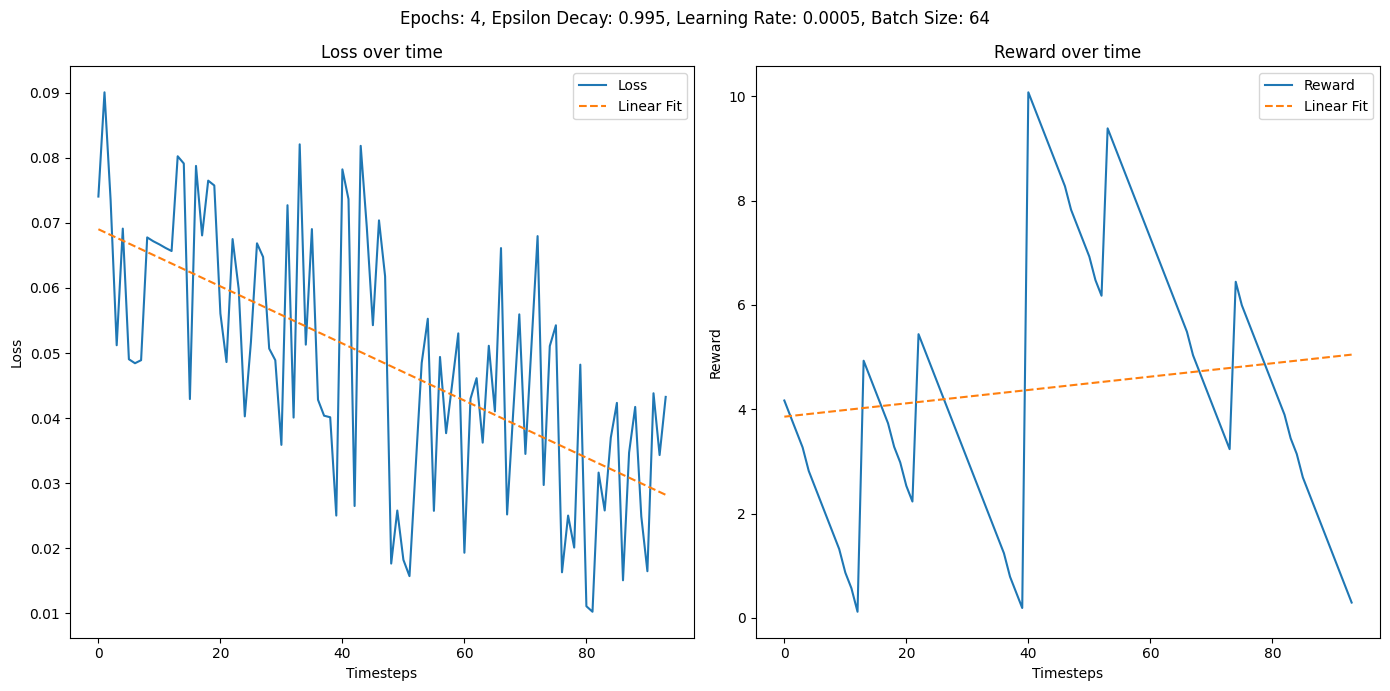

In [9]:
# Read data from CSV files
loss_df = pd.read_csv(folder_path+'/loss.csv')
reward_df = pd.read_csv(folder_path+'/reward.csv')

# Prepare data for linear regression
timesteps_loss = np.arange(len(loss_df['episode'])).reshape(-1, 1)
loss_values = loss_df['loss'].values

timesteps_reward = np.arange(len(reward_df['episode'])).reshape(-1, 1)
reward_values = reward_df['reward'].values

# Linear regression for loss
loss_model = LinearRegression()
loss_model.fit(timesteps_loss, loss_values)
loss_pred = loss_model.predict(timesteps_loss)

# Linear regression for reward
reward_model = LinearRegression()
reward_model.fit(timesteps_reward, reward_values)
reward_pred = reward_model.predict(timesteps_reward)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle(f'Epochs: {episodes}, Epsilon Decay: {epsilon_decay}, Learning Rate: {learning_rate}, Batch Size: {batch_size}')

# Plot 1: Loss over time
axs[0].plot(range(len(loss_df['episode'])), loss_df['loss'], label='Loss')
axs[0].plot(range(len(loss_df['episode'])), loss_pred, label='Linear Fit', linestyle='--')
axs[0].set_xlabel('Timesteps')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss over time')
axs[0].legend()

# Plot 2: Reward over time
axs[1].plot(range(len(reward_df['episode'])), reward_df['reward'], label='Reward')
axs[1].plot(range(len(reward_df['episode'])), reward_pred, label='Linear Fit', linestyle='--')
axs[1].set_xlabel('Timesteps')
axs[1].set_ylabel('Reward')
axs[1].set_title('Reward over time')
axs[1].legend()

plt.savefig(folder_path+'/loss_reward.png')
plt.tight_layout()
plt.show()



In [10]:
# def testing(env, agent, seed):
#     state, info = env.reset(seed=seed)
#     env = gym.wrappers.RecordVideo(env=env, video_folder="../Videos", video_length=0)

#     init_state = process_state_image(state)

#     state_frame_stack_queue = deque([init_state] * agent.frame_stack_num, maxlen=agent.frame_stack_num)
#     total_reward = 0

#     while True:
#         current_state_frame_stack = generate_state_frame_stack_from_queue(state_frame_stack_queue)
#         action = agent.act(current_state_frame_stack)

#         reward = 0
#         for _ in range(frame_stack_num-1):
#             next_state, r, terminated, truncated, info = env.step(action)
#             if terminated or truncated:
#                 done = True
#             else:
#                 done = False
#             reward += r
#             if done:
#                 break

#         total_reward += reward

#         next_state = process_state_image(next_state)
#         state_frame_stack_queue.append(next_state)

#         if done:
#             break

#     print(f"Total reward after playing the game once: {total_reward}")
#     env.close()
#     return total_reward

In [11]:
# # Load the model for testing
# agent.load('trained_model.pth')
# testing(env, agent, seed)